In [5]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential

In [2]:
vetted_RGB = 'merged_data.fits'

with fits.open(vetted_RGB) as hdul:
    data = hdul[1].data  
    
    df_RGB = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [3]:
high_quality = 'high_quality_sample.fits'

with fits.open(high_quality) as hdul:
    # Access the first table extension
    data = hdul[1].data
    
    # Convert to DataFrame
    df_quality = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name] for col in data.columns})


In [4]:
filtered = 'filtered_high_quality_sample.fits'

with fits.open(filtered) as hdul:
    # Access the first table extension
    data = hdul[1].data
    
    # Convert to DataFrame
    df_filtered = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name] for col in data.columns})


In [6]:
# Constants
galcen_distance = 8.2 * u.kpc  # Distance to Galactic centre
z_sun = 25.0 * u.pc           # Sun's distance from Galactic plane
v_sun = CartesianDifferential([11.1, 245.0, 7.25] * u.km / u.s)  # Sun's velocity
gc_frame = Galactocentric(galcen_distance=galcen_distance, z_sun=z_sun, galcen_v_sun=v_sun)

def calculate_vphi_vectorised(df):
    # Convert input columns to astropy quantities
    l = df['l'].values * u.deg
    b = df['b'].values * u.deg
    rpgeo = df['rpgeo'].values * u.pc
    pmra = df['pmra'].values * u.mas / u.yr
    pmdec = df['pmdec'].values * u.mas / u.yr
    vlos = df['radial_velocity'].values * u.km / u.s

    # Create a SkyCoord object in Galactic coordinates
    coords = SkyCoord(l=l, b=b, distance=rpgeo.to(u.kpc),
                      pm_l_cosb=pmra, pm_b=pmdec,
                      radial_velocity=vlos, frame='galactic')

    # Transform to Galactocentric frame
    galactic_coords = coords.transform_to(gc_frame)
    galactic_coords.representation_type = 'cylindrical'

    # Extract rho (cylindrical radius)
    rho_kpc = galactic_coords.rho.to(u.kpc).value  # Cylindrical radius in kpc
    rho_km = rho_kpc * (3.086e+16)  # Convert kpc to km

    # Extract d_phi from Galactocentric frame (signed angular velocity)
    d_phi_rad_s = galactic_coords.d_phi.to(u.rad / u.s).value

    # Compute v_phi
    v_phi = - rho_km * d_phi_rad_s  # Linear azimuthal velocity in km/s
    return v_phi


In [7]:
# Calculate v_phi for the entire DataFrame
df_filtered['v_phi'] = calculate_vphi_vectorised(df_filtered)

df_filtered['v_phi'].describe()

count    3.079600e+06
mean     2.176391e+02
std      5.508371e+01
min     -4.711791e+02
25%      1.932340e+02
50%      2.225321e+02
75%      2.480774e+02
max      8.478010e+02
Name: v_phi, dtype: float64

In [8]:
# Calculate v_phi for the entire DataFrame
df_RGB['v_phi'] = calculate_vphi_vectorised(df_RGB)

df_RGB['v_phi'].describe()

count    1.257406e+07
mean     2.134471e+02
std      5.397590e+01
min     -6.067779e+02
25%      1.934472e+02
50%      2.207687e+02
75%      2.434168e+02
max      1.042007e+03
Name: v_phi, dtype: float64

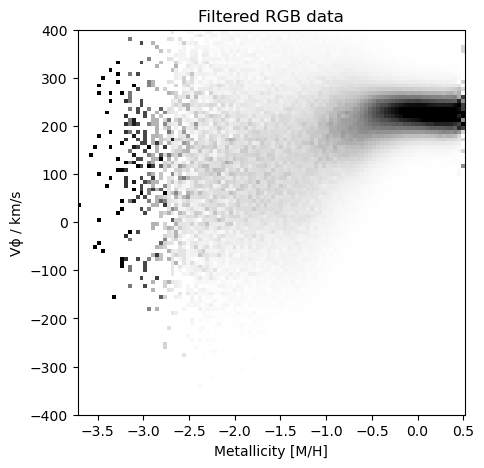

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Ensure no NaN values in the required columns
df_filtered = df_filtered.dropna(subset=['mh_xgboost', 'v_phi'])

# Extract metallicity and v_phi
metallicity = df_filtered['mh_xgboost']
v_phi = df_filtered['v_phi']

# Define the number of bins
num_bins = 100

# Create the bin edges for metallicity and v_phi
metallicity_bins = np.linspace(metallicity.min(), metallicity.max(), num_bins + 1)
v_phi_bins = np.linspace(-400, 400, num_bins + 1)

# Create the 2D histogram
hist, metallicity_edges, v_phi_edges = np.histogram2d(
    metallicity, v_phi, bins=[metallicity_bins, v_phi_bins]
)

# Column-normalise the histogram (normalise along the metallicity axis)
metallicity_sums = hist.sum(axis=1, keepdims=True)  # Sum of each metallicity section
metallicity_sums[metallicity_sums == 0] = 1  # Avoid division by zero
hist_normalised = hist / metallicity_sums  # Normalise each metallicity section

# Plot the normalised histogram
plt.figure(figsize=(5, 5))
plt.pcolormesh(
    metallicity_edges, v_phi_edges, hist_normalised.T,
    cmap='Greys', norm=Normalize(vmin=0, vmax=np.percentile(hist_normalised, 99))
)

# Set axis labels and title
plt.xlabel('Metallicity [M/H]')
plt.ylabel('Vϕ / km/s')
plt.title('Filtered RGB data')
plt.ylim(-400, 400)
plt.show()


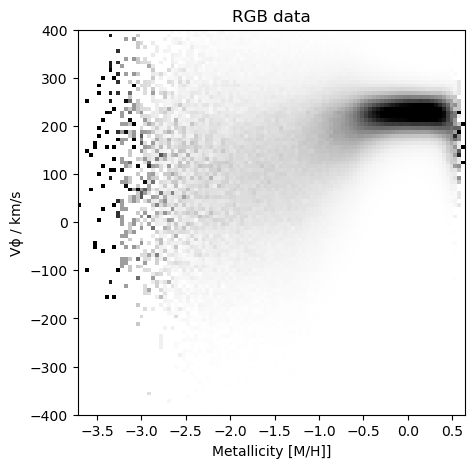

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Ensure no NaN values in the required columns
df_RGB = df_RGB.dropna(subset=['mh_xgboost', 'v_phi'])

# Extract metallicity and v_phi
metallicity = df_RGB['mh_xgboost']
v_phi = df_RGB['v_phi']

# Define the number of bins
num_bins = 100

# Create the bin edges for metallicity and v_phi
metallicity_bins = np.linspace(metallicity.min(), metallicity.max(), num_bins + 1)
v_phi_bins = np.linspace(-400, 400, num_bins + 1)

# Create the 2D histogram
hist, metallicity_edges, v_phi_edges = np.histogram2d(
    metallicity, v_phi, bins=[metallicity_bins, v_phi_bins]
)

# Column-normalise the histogram (normalise along the metallicity axis)
metallicity_sums = hist.sum(axis=1, keepdims=True)  # Sum of each metallicity section
metallicity_sums[metallicity_sums == 0] = 1  # Avoid division by zero
hist_normalised = hist / metallicity_sums  # Normalise each metallicity section

# Plot the normalised histogram
plt.figure(figsize=(5, 5))
plt.pcolormesh(
    metallicity_edges, v_phi_edges, hist_normalised.T,
    cmap='Greys', norm=Normalize(vmin=0, vmax=np.percentile(hist_normalised, 99))
)

# Set axis labels and title
plt.xlabel('Metallicity [M/H]]')
plt.ylabel('Vϕ / km/s')
plt.title('RGB data')
plt.ylim(-400, 400)
plt.show()
